# Repeat Until Success Circuits

The repeat-until-success circuit is a mechanism for applying a non-determinstic operation on a qubit such that, in the case of a failed operation, the qubit can be returned to its original state (and hence one can try again).  In this demo, we will compose two RUS circuits to create an "effective" nonlinearity. Below, we plot the function q(x)=arctan(tan^2(x)).  The important behavior of this function is that multiple compositions of it generate an approximate step function.  This behavior is an important step in how deep neural networks can learn nonlinear phenomena.

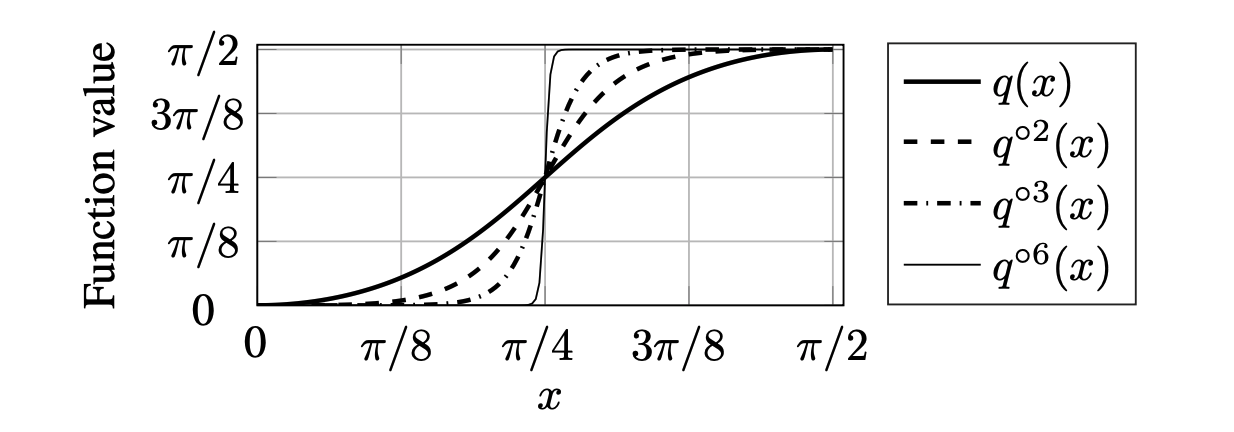

Below, we describe the theoretical application of a single RUS circuit, and then a diagram of the circuit which applies this operation (in the yellow box).  The input qubit |psi> is the target qubit, and |0> is an ancilla needed to apply the circuit.

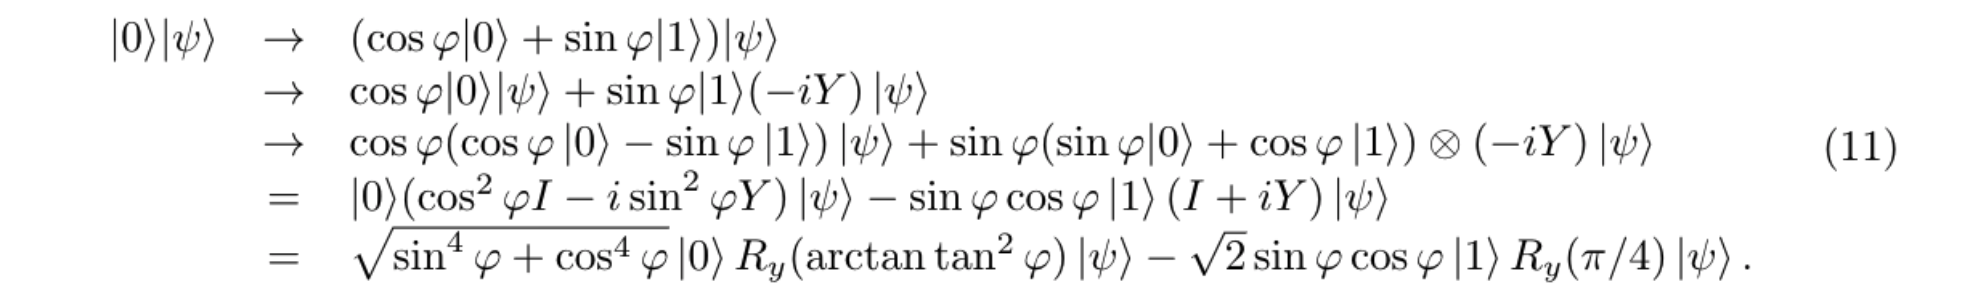

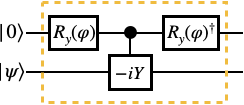

Let us consider the output state of the circuit.  The first term (|0>|psi>) corresponds to a successful application of the function q(x) to the argument of an R_y gate applied to |psi>.  Hence, by measuring |0> on the first qubit, we have ensured the desired operation has occurred on the target qubit.

On the other  hand, if we measure |1> on the first qubit, we have instead applied an R_y rotation of pi/4 to the target qubit.  The idea of a repeat-until-success circuit, then, is to apply a R_y(-pi/4) rotation to the target qubit and reset the first qubit to |0> *on the condition that this measurement occurs*.  After doing so, we have returned to the state |0>|psi> and can apply the RUS block again.

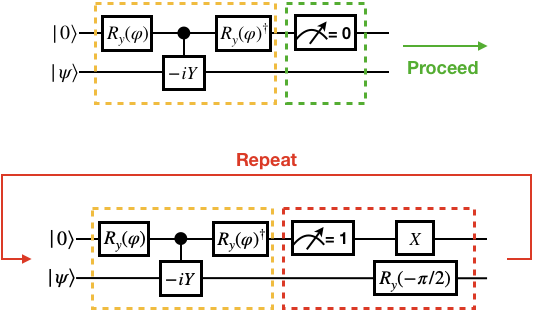

In this demo, we will construct some variations of a circuit which composes *two* iterations of the RUS circuits.  These variations will differ on the experimental features that are needed to apply them.  They are:
- Post-selected gates: 
This approach requires no "special" hardware features, and relies on simply running the circuit many times to extract the desired information.  When all of the ancilla states measure |0>, the desired operation has been applied.  This is not an efficient scheme when composing many RUS circuits together since, in the worse case, the probability of getting all |0> on ancillas is (1/2)^(# of ancillas).  
- Feedforward:
This approach actually warrants the name "repeat until success".  In this case, measurements are made sequentially on the ancillas.  When the measurement reads |0>, the circuit proceeds to the next block.  If the measurement reads |1>, an "undo" gate is applies and the circuit loops and reapplies the previous block, and measurement occurs again.  This repeats until the measurement exits the loop by reading |0>.  This is efficient when composing many RUS circuits together, but will be limited by error if many repetitions of the circuit blocks need to be applied.

## Import Libraries

In [1]:
# import libraries
%matplotlib inline
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'errorbar.capsize': 3})
from matplotlib.ticker import MaxNLocator
import numpy as np
from qutip import *
from scipy import optimize
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer
from qiskit.tools.visualization import circuit_drawer
from math import pi
from decimal import *
from qiskit.converters import circuits_to_qobj as to_qasm
from qiskit.qobj._converter import *

backend = BasicAer.get_backend('qasm_simulator')

/anaconda3/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


## Post-selected RUS Circuit

As a first demonstration, we will generate the post-selected version of the circuit (using Qiskit).  We have chosen the target qubit |psi>=|0>, so that we can measure in the computational basis at the end to generate a plot that looks similar to q(q(x)). A diagram of the abstract components and the specific circuit which implements it follow:

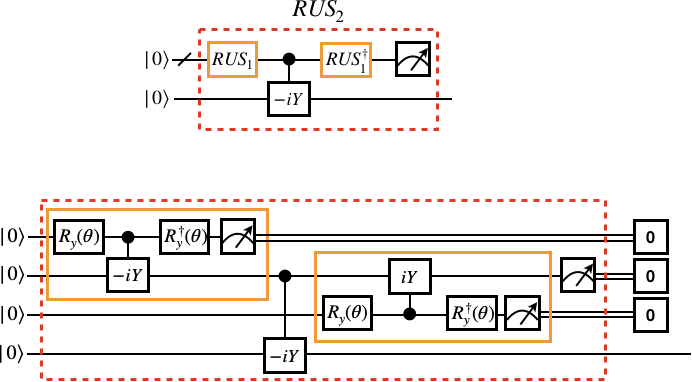

In [2]:
## Generate the post-selected circuit using Qiskit

def generate_rus_ps(phi):
    #Creates a Qiskit circuit object corresponding to a Post-Selected RUS circuit.
    q = QuantumRegister(4, 'q')
    c1 = ClassicalRegister(1, 'c1')
    c2 = ClassicalRegister(1, 'c2')
    c3 = ClassicalRegister(1, 'c3')
    c4 = ClassicalRegister(1, 'c4')
    qc = QuantumCircuit(q,c1,c2,c3,c4)
    
    #RUS Block 1
    qc.ry(phi,q[0])
    qc.u1(-pi/2,q[0])
    qc.cy(q[0],q[1])
    qc.ry(-phi,q[0])
    qc.measure(q[0],c1[0])

    #Apply control -iY
    qc.u1(-pi/2,q[1])
    qc.cy(q[1],q[3])
    
    #RUS Block 2
    qc.ry(phi,q[2])
    qc.u1(-pi/2,q[2])
    qc.cy(q[2],q[1])
    qc.ry(-phi,q[2])
    qc.measure(q[2],c2[0])
    
    #Final control
    qc.measure(q[1],c3[0])
    
    #Final measurement
    qc.measure(q[3],c4[0])
    return qc

#print(generate_rus_ps(pi/2))

## Run the RUS circuit

This function applies the above circuit, breaking `phi` into increments of `pi`/`num_bins` and post-selects on measurement results with only 0's in the ancilla (the total number of measurements before post-selection is given by 'shots').  The print_counts variable can be used to check the exact results. Below is an example of the circuit with `phi` in increments of `pi`/`16` with 1000 shots taken for each `phi`.  Note that when `phi` gets close to `pi`/`2`, the count rate is low.  This is because we are post-selecting only on the successful applications of the RUS circuit, which occur only about 1/8 of the time.  The feedforward circuit will have higher count rates, because the circuit elements are *actually* repeated until success.

In [3]:
def rus_counts(num_bins,shots=1000,print_counts=False):
    #Runs a Post-Selected RUS circuit experiment over an interval of 0 to pi in increments of pi/num_bins.
    #If print_counts=True, prints the correspoding data from the experiment.
    bin_values = []
    bin_counts = []
    for k in range(num_bins):
        phi = k*pi/(num_bins-1)
        phi_str = '%.2f' % phi
        qc = generate_rus_ps(k*pi/(num_bins-1))
        job = execute(qc, backend, shots=shots)
        x = job.result().get_counts(qc)
        try: 
            y = x['1 0 0 0']
        except:
            y = 0
        try: 
            z = x['0 0 0 0']
        except:
            z = 0
        w = y/(z+y)
        bin_values.append(w)
        bin_counts.append(z+y)
        if print_counts:
            print('Phi: '+str(phi_str)+'   '+'0 Count: '+str(z)+'   '+'1 Count: '+str(y)+'   '+'Fraction of 1 counts : '+'%.2f' % w)
    return [bin_values,bin_counts]

print(rus_counts(16,1000,True))

/anaconda3/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Phi: 0.00   0 Count: 1000   1 Count: 0   Fraction of 1 counts : 0.00
Phi: 0.21   0 Count: 960   1 Count: 0   Fraction of 1 counts : 0.00
Phi: 0.42   0 Count: 840   1 Count: 0   Fraction of 1 counts : 0.00
Phi: 0.63   0 Count: 671   1 Count: 0   Fraction of 1 counts : 0.00
Phi: 0.84   0 Count: 504   1 Count: 2   Fraction of 1 counts : 0.00
Phi: 1.05   0 Count: 334   1 Count: 4   Fraction of 1 counts : 0.01
Phi: 1.26   0 Count: 207   1 Count: 15   Fraction of 1 counts : 0.07
Phi: 1.47   0 Count: 104   1 Count: 38   Fraction of 1 counts : 0.27
Phi: 1.68   0 Count: 41   1 Count: 92   Fraction of 1 counts : 0.69
Phi: 1.88   0 Count: 14   1 Count: 173   Fraction of 1 counts : 0.93
Phi: 2.09   0 Count: 6   1 Count: 294   Fraction of 1 counts : 0.98
Phi: 2.30   0 Count: 0   1 Count: 486   Fraction of 1 counts : 1.00
Phi: 2.51   0 Count: 0   1 Count: 679   Fraction of 1 counts : 1.00
Phi: 2.72   0 Count: 0   1 Count: 836   Fraction of 1 counts : 1.00
Phi: 2.93   0 Count: 0   1 Count: 951   Frac

## Plot the Performance of Post-Selected RUS

We now plot the above data.  Note that the error bars toward the edges of the plot are smaller than those in the middle; this is because the post-selection is reducing the count rate by a factor of approximately 1/8.

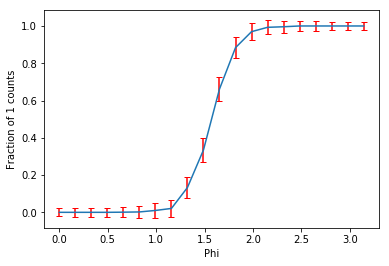

In [4]:
def plot_rus(num_bins,shots,error_bars=True):
    #Plots a Post-Selected RUS circuit
    x_axis = []
    data = rus_counts(num_bins,shots)
    errors = []
    for i in data[1]:
        errors.append((1/i)**.5)
    for k in range(num_bins):
        x_axis.append(k*pi/(num_bins-1))
    if error_bars:
        plt.errorbar(x_axis,data[0],yerr=errors,ecolor='red')
    else:
        plt.plot(x_axis,data[0])
    plt.ylabel('Fraction of 1 counts')
    plt.xlabel('Phi')
    plt.show()
    
plot_rus(20,2000)

For a bonus visual of what happens to the target qubit as `phi` rotates, see: https://algassert.com/quirk#circuit={%22cols%22:[[%22Y^t%22],[%22Z^-%C2%BD%22],[%22%E2%80%A2%22,%22Y%22],[%22Y^-t%22],[%22Measure%22],[%22|0%E2%9F%A9%E2%9F%A80|%22],[%22%E2%80%A2%22,%22~erma%22],[1,%22%E2%80%A2%22,1,%22Y%22],[1,1,%22Y^t%22],[1,1,%22Z^-%C2%BD%22],[1,%22Y%22,%22%E2%80%A2%22],[1,1,%22Y^-t%22],[1,1,%22Measure%22],[1,1,%22|0%E2%9F%A9%E2%9F%A80|%22],[1,%22~erma%22,%22%E2%80%A2%22],[1,%22Measure%22],[1,%22|0%E2%9F%A9%E2%9F%A80|%22],[1,%22%E2%80%A2%22,1,%22~erma%22]],%22gates%22:[{%22id%22:%22~58c2%22,%22name%22:%22i%22,%22matrix%22:%22{{i,0},{0,i}}%22},{%22id%22:%22~erma%22,%22matrix%22:%22{{%E2%88%9A%C2%BD,-%E2%88%9A%C2%BD},{%E2%88%9A%C2%BD,%E2%88%9A%C2%BD}}%22},{%22id%22:%22~7co2%22,%22name%22:%22-i%22,%22matrix%22:%22{{-i,0},{0,-i}}%22},{%22id%22:%22~r5rq%22,%22name%22:%22ryinv%22,%22matrix%22:%22{{-%E2%88%9A%C2%BD,%E2%88%9A%C2%BD},{-%E2%88%9A%C2%BD,-%E2%88%9A%C2%BD}}%22}]}

(Note that the above illustration of the circuit is a little hacky, and doesn't correspond *exactly* to the circuit in this tutorial, but has the same effect after post-selection)

## Feedforward RUS Circuit

Now, we will implement a version of the same circuit, but now applying a repetition component.  However, note that OpenQASM/Qiskit does not have the functionality to apply precisely the circuit that we want.  That is, we cannot tell the circuit to simply loop until we get a desired outcome.  Instead, what we can do is apply a fixed number of repetitions(`num_reps`) of the RUS blocks, such that all the gates in these blocks are conditioned on a classical register which is set to be the measurement at the end of the block.  Once the desired measurement occurs, the gates in the block are "turned off" for the remainder of the repetitions.

To keep things simple, we will repeat the RUS_1 block but not the entire RUS circuit.  Also, for coding simplicity, we have added an X gate just before the measurement.  This only changes post-selection criteria from |0> to |1> on the first and third qubit.

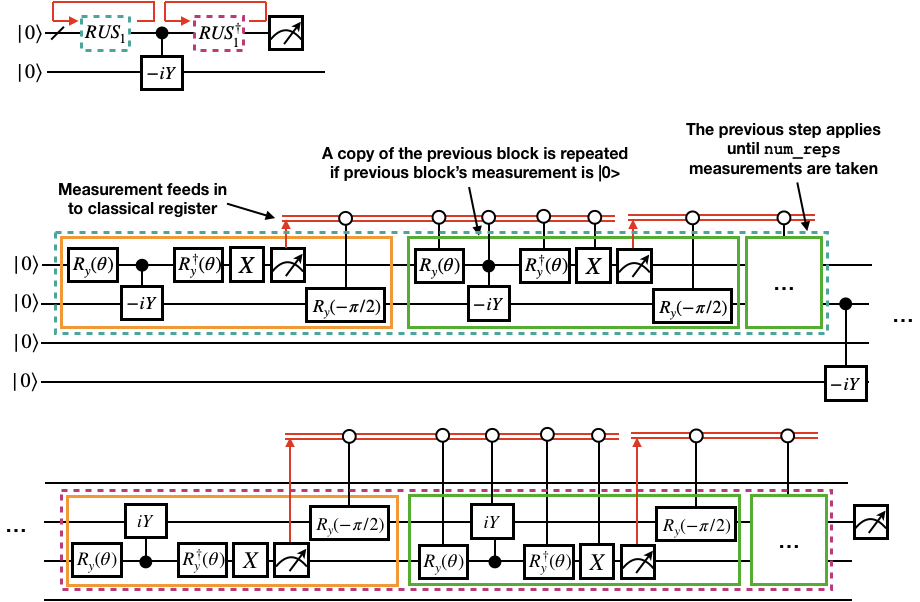

In [5]:
## Generate the FF circuit using Qiskit

def generate_rus_ff(phi, num_reps):
    #Creates a Qiskit circuit object corresponding to a Feedforward RUS circuit.
    q = QuantumRegister(4, 'q')
    c1 = ClassicalRegister(1, 'c1')
    c2 = ClassicalRegister(1, 'c2')
    c3 = ClassicalRegister(1, 'c3')
    c4 = ClassicalRegister(1, 'c4')
    qc = QuantumCircuit(q,c1,c2,c3,c4)
    
    #RUS Block 1
    for j in range(num_reps):
        qc.ry(phi,q[0]).c_if(c1,0)
        qc.u1(-pi/2,q[0]).c_if(c1,0)
        qc.cy(q[0],q[1]).c_if(c1,0)
        qc.ry(-phi,q[0]).c_if(c1,0)
        qc.x(q[0]).c_if(c1,0)
        qc.measure(q[0],c1[0])
        qc.ry(-pi/2,q[1]).c_if(c1,0)
    
    #Apply control -iY
    qc.u1(-pi/2,q[1])
    qc.cy(q[1],q[3])
    
    #RUS Block 2
    for j in range(num_reps):
        qc.ry(phi,q[2]).c_if(c3,0)
        qc.u1(-pi/2,q[2]).c_if(c3,0)
        qc.cy(q[2],q[1]).c_if(c3,0)
        qc.ry(phi,q[2]).c_if(c3,0)
        qc.x(q[2]).c_if(c3,0)
        qc.measure(q[2],c3[0])
        qc.ry(-pi/2,q[1]).c_if(c3,0)
    
    #Final control
    qc.measure(q[1],c2[0])
    qc.ry(-pi/2,q[3]).c_if(c2,1)
    
    #Final measurement
    qc.measure(q[3],c4[0])
    #print(qc.draw())
    return qc

## Plot the Performance of Feedforward RUS

Note that we expect to the see a similar plot as we did with the post-selected circuit.

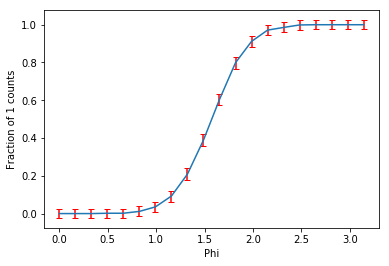

In [6]:
def rus_counts_ff(num_bins,shots=1000,print_counts=False):
    #Runs a Feedforward RUS circuit experiment over an interval of 0 to pi in increments of pi/num_bins.
    #If print_counts=True, prints the correspoding data from the experiment.
    bin_values = []
    bin_counts = []
    for k in range(num_bins):
        phi = k*pi/(num_bins-1)
        phi_str = '%.2f' % phi
        qc = generate_rus_ff(k*pi/(num_bins-1),5)
        job = execute(qc, backend, shots=shots)
        x = job.result().get_counts(qc)
        try: 
            y = x['1 1 0 1']
        except:
            y = 0
        try: 
            z = x['0 1 0 1']
        except:
            z = 0
        w = y/(z+y)
        bin_values.append(w)
        bin_counts.append(z+y)
        if print_counts:
            print('Phi: '+str(phi_str)+'   '+'0 Count: '+str(z)+'   '+'1 Count: '+str(y)+'   '+'Fraction of 1 counts : '+'%.2f' % w)
    return [bin_values,bin_counts]

def plot_rus_ff(num_bins,shots,error_bars=True):
    #Plots a Feedforward RUS circuit
    x_axis = []
    data = rus_counts_ff(num_bins,shots)
    errors = []
    for i in data[1]:
        errors.append((1/i)**0.5)
    for k in range(num_bins):
        x_axis.append(k*pi/(num_bins-1))
    if error_bars:
        plt.errorbar(x_axis,data[0],yerr=errors,ecolor='red')
    else:
        plt.plot(x_axis,data[0])
    plt.ylabel('Fraction of 1 counts')
    plt.xlabel('Phi')
    plt.show()

plot_rus_ff(20,2000)

## Compare the performance between Post-Selected RUS and Feedforward RUS

The difference between the output of these two circuits is a little bit hidden---it is manifested in the variance of the data points.  Here, we choose a smaller number of shots to emphasize this difference.

The Post-Selected RUS looks like:


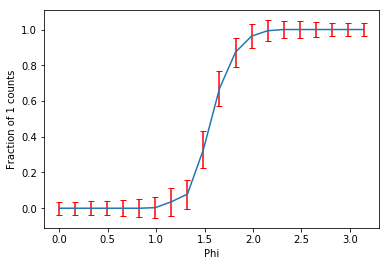

The Feedforward RUS looks like:


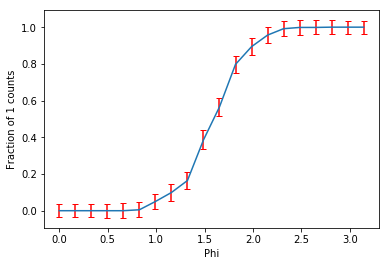

In [7]:
print('The Post-Selected RUS looks like:')
plot_rus(20,800)
print('The Feedforward RUS looks like:')
plot_rus_ff(20,800)

## Write QASM

To write the above circuits to a separate `.qasm` file, use the below `write_qasm` function.  

In [8]:
def get_qasm(circuit,backend):
    #Returns the .qasm of a Qiskit circuit
    x = to_qasm(circuit,backend)
    y = qobj_to_dict_current_version(x)
    return y['experiments'][0]['header']['compiled_circuit_qasm']

#print(get_qasm(generate_rus_ps(pi/2),backend))

def write_qasm(file_name,circuit,backend):
    #Writes a circuit's corresponding .qasm to 'file_name.qasm'
    x = get_qasm(circuit,backend)
    file = open(file_name+'.qasm',"w") 
    file.write(x)
    file.close()
    return 'QASM written to '+file_name+'.qasm'

write_qasm('rus_ps',generate_rus_ps(pi/2),backend)
write_qasm('rus_ff',generate_rus_ff(pi/2,3),backend)

'QASM written to rus_ff.qasm'